(creating-observations-doc)=
# Loading observations

As it was mention in the [introduction to observations](../1_introduction/1_observations.ipynb) $\mathrm{LiMe}$ can create observations directly from some instrument *.fits* files:

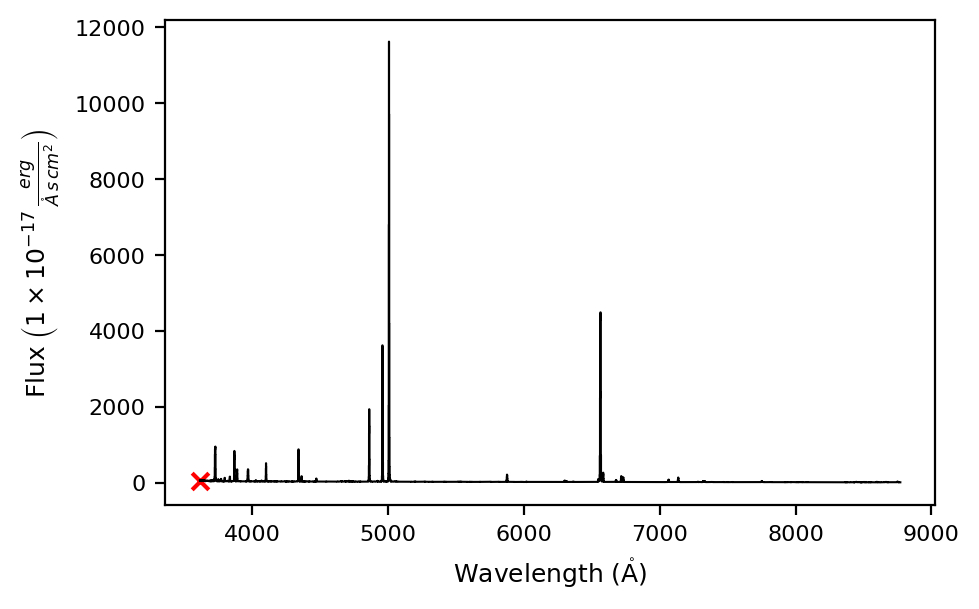

In [2]:
import numpy as np
from astropy.io import fits
from pathlib import Path
from astropy.wcs import WCS
import lime
import astropy

# Specifying 2_guides:
data_folder = Path('../0_resources/spectra')
sloan_SHOC579 = data_folder/'sdss_dr18_0358-51818-0504.fits'

# Create the observation
shoc579 = lime.Spectrum.from_file(sloan_SHOC579, instrument='sdss', redshift=0.0475)

# Plot the spectrum
shoc579.plot.spectrum(rest_frame=True)

However, direct reading for many instruments is still not available or you spectra have a different origin or calibration. In this case you will need to access the data yourself. In this guide we are going to show some examples: 

<div class="alert alert-info">

**Please remember:** The reader is recomended to check the [official *.fits* documentation](https://docs.astropy.org/en/stable/io/fits/) from [astropy](https://www.astropy.org/) to familiarize with this format.

</div>

## a) Osiris long-slit

In the sample  [examples/sample_data](https://github.com/Vital-Fernandez/lime/tree/master/examples/sample_data) you have the spectrum from the OSIRIS instrument at the GTC (Gran Telescopio de Canarias). This file contains the flux array but you must reconstruct the wavelength array from the header ``CRVAL1``, ``CD1_1`` and ``NAXIS1`` keys:

In [3]:
# Spectrum address
fits_path = data_folder/'gp121903_osiris.fits'

# Data extension index
extension = 0

# Open the fits file
with fits.open(fits_path) as hdul:
    flux_array, header = hdul[extension].data, hdul[extension].header

In the code above, we use the **with** [context manager](https://realpython.com/python-with-statement/). This structure makes sure that the file is closed once we extract the data. This is a safe practice in the case of large *.fits* files.

Now, we are going to compute the wavelength array:

In [5]:
#Lowest wavelength value
w_min = header['CRVAL1']

# Resolution in angstroms per pixel
dw = header['CD1_1']

# Number of pixels
n_pixels = header['NAXIS1']

# Array computation
w_max = w_min + dw * n_pixels
wave_array = np.linspace(w_min, w_max, n_pixels, endpoint=False)
print(wave_array)

[ 3626.97753906  3629.04561139  3631.11368372 ... 10236.5367069
 10238.60477923 10240.67285156]


The units on the spectrum arrays should also be specified on the *.fits* header:

In [6]:
print(f'Wavelength array: {header["WAT1_001"]}')
print(f'Flux array: {header["BUNIT"]}')

Wavelength array: wtype=linear label=Wavelength units=Angstroms
Flux array: erg/cm2/s/A


Now, we are going to create the [$\tt{lime.Spectrum}$](https://lime-stable.readthedocs.io/en/latest/introduction/api.html#lime.Spectrum) from the raw data. This object has the following arguments:
* **redshift**: Object redshift
* **norm_flux** Flux normalization
* **units_wave**: Spectrum wavelength units. The default values is Angstroms.
* **units_flux**: Spectrum flux units. The default value is FLAM $\mathrm{\left(\frac{\text{erg}}{\text{s} \cdot \text{cm}^2 \cdot \mathring{A}}\right)}$
* **pixel_mask**: Indeces to mask or entries to mask on the wavelength, flux and uncertainty arrays.
* **res_power**: Observation resolving power.

LiMe INFO: The observation does not include a normalization but the mean flux value is below 0.001. The flux will be automatically normalized by 1.000000045813705e-18.


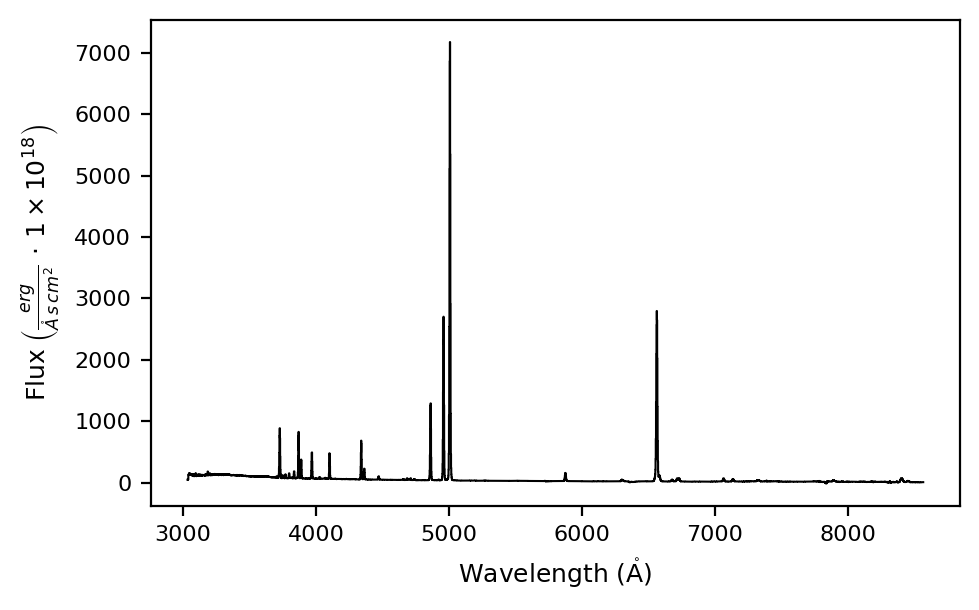

In [7]:
obj = lime.Spectrum(wave_array, flux_array, redshift=0.19531)
obj.plot.spectrum(rest_frame=True)

In the observation above, we did not introduce a flux normalization but $\mathrm{LiMe}$ calculated one for us.

## b) Sloan long-slit

$\mathrm{LiMe}$ can read *.fits* files from the [SDSS survey](https://skyserver.sdss.org/dr18/) survey as we saw above, but let's check this optional method:

In [8]:
# Open the fits file
extension = 1
with fits.open(sloan_SHOC579) as hdul:
    data = hdul[extension].data
    header = hdul[extension].header

The flux key indexes the flux. This value is normalized by so we are going to define the units including this scale:

In [9]:
flux_array = data['flux']
units_flux = '1e-17*FLAM'

The flux uncertainty is stored as the inversed of the variance. The bad values in this array are set to zero, hence, we are going to mask these values to compute the error spectrum.

In [10]:
ivar_array = data['ivar']
err_array = np.sqrt(1/ivar_array)
pixel_mask = ivar_array == 0

/tmp/ipykernel_158862/3510536718.py:2: RuntimeWarning: divide by zero encountered in divide
  err_array = np.sqrt(1/ivar_array)


Finally, the wavelength array is stored in logarithmic scale and they are accessed via the ``loglam`` key:

In [11]:
wave_vac_array = np.power(10, data['loglam'])

Now we can create the ``Spectrum`` object:

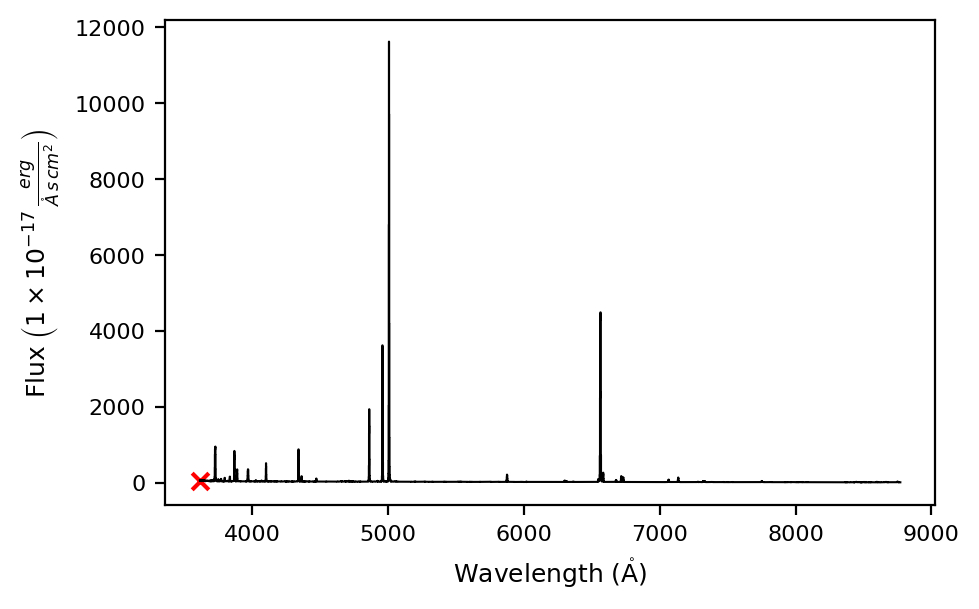

In [12]:
obj = lime.Spectrum(wave_vac_array, flux_array, err_array, pixel_mask=pixel_mask, units_flux=units_flux, redshift=0.0475)
obj.plot.spectrum(rest_frame=True)

If you don't not provide a pixel mask, $\mathrm{LiMe}$ will try to mask non-physical entries:

LiMe INFO: The input err_flux array contains "inf" entries a pixel_mask will be generated automatically


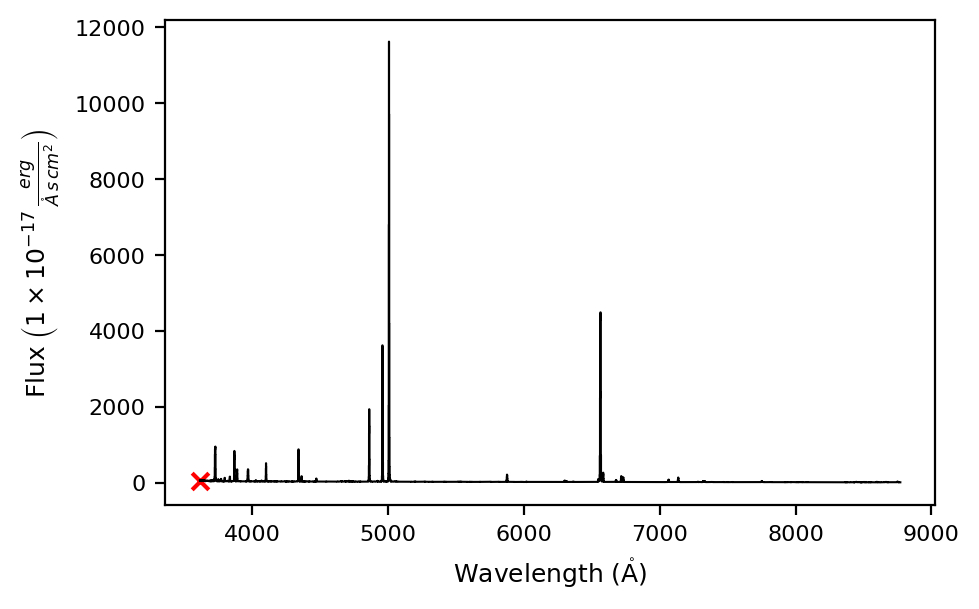

In [13]:
obj = lime.Spectrum(wave_vac_array, flux_array, err_array, units_flux=units_flux, redshift=0.0475)
obj.plot.spectrum(rest_frame=True)

<div class="alert alert-info">

**Please remember:** The reader is adviced to define their own pixel mask, even if $\mathrm{LiMe}$ will check for ``np.nan`` and ``np.inf`` entries

</div>

## c) MANGA IFU cube

Now, we are going to open the MANGA integrated field unit observation of SHOC579:

In [14]:
fits_path = data_folder/'manga-8626-12704-LOGCUBE.fits.gz'

This file is compressed, however, the astropy.io.fits.open can read it. However, keep in mind that reading compressed files takes more time:

In [16]:
# Open the MANGA cube fits file
with fits.open(fits_path) as hdul:

    # Wavelength 1D array
    wave = hdul['WAVE'].data

    # Flux 3D array
    flux_cube = hdul['FLUX'].data
    units_flux = '1e-17*FLAM'

    # Convert inverse variance cube to standard error, masking 0-value pixels first
    ivar_cube = hdul['IVAR'].data
    err_cube = np.sqrt(1/ivar_cube)
    pixel_mask_cube = ivar_cube == 0
    
    # Header
    hdr = hdul['FLUX'].header

/tmp/ipykernel_158862/2371804064.py:13: RuntimeWarning: divide by zero encountered in divide
  err_cube = np.sqrt(1/ivar_cube)


The header of .fits spectra usually contains the astronomical coordinates of the observation. $\mathrm{LiMe}$ relies on [World Coordidnate System](https://docs.astropy.org/en/stable/visualization/wcsaxes/index.html) to plot the IFU data and export the coordinates to the output *.fits* files with your measurements. You can create the WCS object from the corresponding *.fits* header:

In [17]:
# WCS from the observation
wcs = WCS(hdr)

a string value was expected. [astropy.wcs.wcs]


Now, we have all the create our Cube object:

In [18]:
cube = lime.Cube(wave, flux_cube, err_cube, redshift=0.0475, units_flux=units_flux, pixel_mask=pixel_mask_cube)

Now you can extract individual spaxels to analyse the object lines. Each spaxel will have its corresponding error spectrum and pixel mask

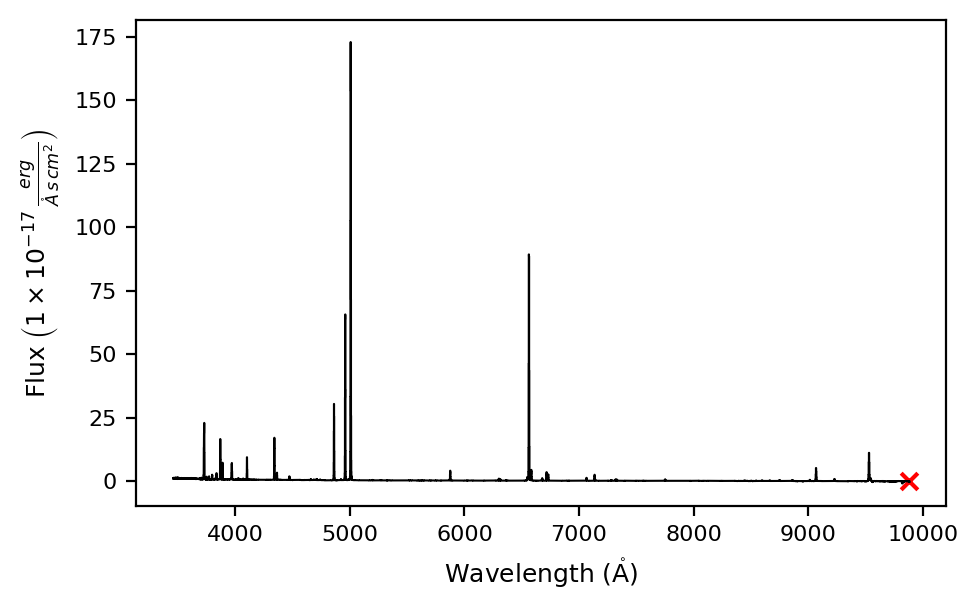

In [19]:
# Extract spaxel
spaxel = cube.get_spectrum(38, 35)

# Plot spectrum
spaxel.plot.spectrum(rest_frame=True)

## Takeaways
* $\mathrm{LiMe}$ can create observations directly from some *.fits* files for some instruments. Otherwise you can always create $\tt{lime.Spectrum}$ or $\tt{lime.Cube}$ objects directly from the scientific data.
* $\mathrm{LiMe}$ will compute a pixel mask for non physical entries and compute a flux normalization if the user does not provide them. However, the user is recomended to provide his/her own.